# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://data.vancouver.ca/datacatalogue/propertyTax.htm). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2019.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [50]:
import pandas as pd

df = pd.read_csv("property_tax_report_2019.csv")


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

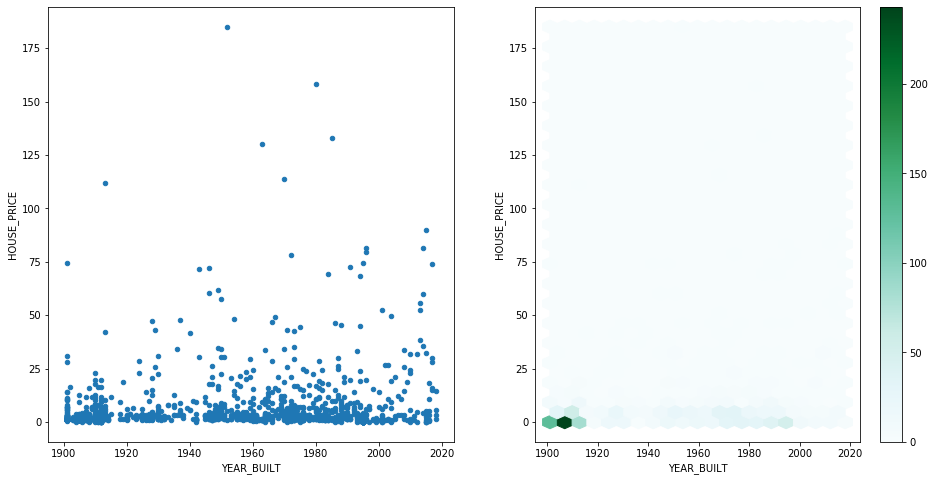

In [51]:
import numpy as np
import matplotlib.pyplot as plt

#Setting axes and subplots
fig, axes = plt.subplots(1, 2,figsize=(16,8))

df1 = df[df['YEAR_BUILT'] > 1900]
df1 = df1[df1['LEGAL_TYPE']=='LAND']
df1 = df1[df1['PROPERTY_POSTAL_CODE'].str.startswith('V6A',na=False)]

df1.plot.scatter(x='YEAR_BUILT',y='HOUSE_PRICE',ax=axes[0])
df1.plot.hexbin(x="YEAR_BUILT",  y="HOUSE_PRICE", gridsize=(20,20),ax=axes[1]);




Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The scatter plot shows that there are few houses that have very high house prices.
2. The hexbin plot shows that most of the houses are built more around the range of 1900-1920.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


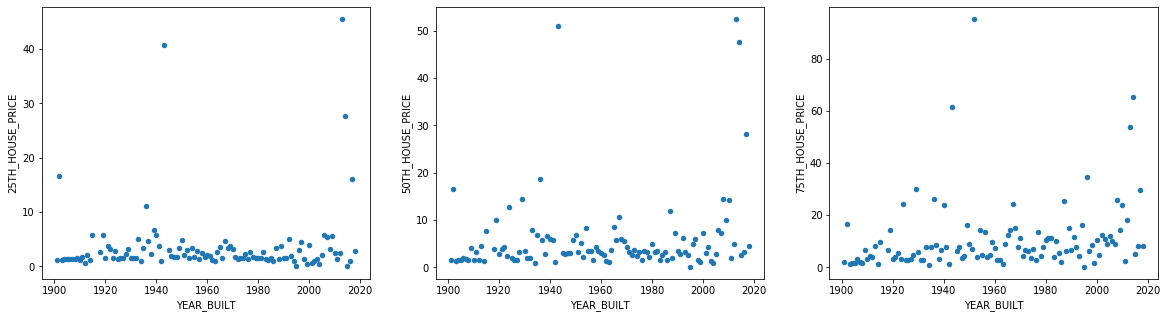

In [76]:
#Getting the quantile values for each year
df_25 = df1.groupby(['YEAR_BUILT']).agg({'HOUSE_PRICE':lambda x:x.quantile(0.25)}).reset_index().rename(columns={"HOUSE_PRICE": "25TH_HOUSE_PRICE"})
df_50 = df1.groupby(['YEAR_BUILT']).agg({'HOUSE_PRICE':lambda x:x.quantile(0.50)}).reset_index().rename(columns={"HOUSE_PRICE": "50TH_HOUSE_PRICE"})
df_75 = df1.groupby(['YEAR_BUILT']).agg({'HOUSE_PRICE':lambda x:x.quantile(0.75)}).reset_index().rename(columns={"HOUSE_PRICE": "75TH_HOUSE_PRICE"})
df_25.head()
# Plot layouts
fig, axes = plt.subplots(1, 3,figsize=(20,5))

#Plotting scatter plots
df_25.plot.scatter(x='YEAR_BUILT',y='25TH_HOUSE_PRICE',ax=axes[0])
df_50.plot.scatter(x='YEAR_BUILT',y='50TH_HOUSE_PRICE',ax=axes[1])
df_75.plot.scatter(x='YEAR_BUILT',y='75TH_HOUSE_PRICE',ax=axes[2]);

df_25_75 = pd.merge(df_25, df_50, how='inner', on='YEAR_BUILT')
dfcor = pd.merge(df_25_75,df_75,how='inner',on='YEAR_BUILT')

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. 2000-2020 saw the most highest prices of houses as most of them lie within the 75th percentile.
2. The 25th percentile house prices are around the uniform range.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [77]:
def calc_pearson(df, x, y):
    #<-- Write Your Code -->
    covariance=df[x].cov(df[y])
    std_x=df[x].std()
    std_y=df[y].std()
    pearson_coeff=covariance/(std_x*std_y)
    return pearson_coeff
    
    

def calc_spearman(df, x, y):
    x_rank=df[x].rank()
    y_rank=df[y].rank()
    rank_covariance=x_rank.cov(y_rank)
    std_x_rank=x_rank.std()
    std_y_rank=y_rank.std()
    spearman_coeff=rank_covariance/(std_x_rank*std_y_rank)
    return spearman_coeff


Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [78]:
print(dfcor.head(10))
print()

for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1901.0          1.189925           1.50700           2.00050
1      1902.0         16.614000          16.61400          16.61400
2      1903.0          1.246150           1.42620           1.50630
3      1904.0          1.454500           1.57920           1.61430
4      1905.0          1.378200           1.49100           1.67300
5      1906.0          1.452350           2.01700           3.14720
6      1907.0          1.448550           1.71800           2.05500
7      1908.0          1.321000           1.47480           1.69700
8      1909.0          1.500225           4.04085           6.85100
9      1910.0          1.223000           1.59700           3.27395

25TH_HOUSE_PRICE	 pearson=0.109166	 spearman=0.026466
50TH_HOUSE_PRICE	 pearson=0.180771	 spearman=0.172998
75TH_HOUSE_PRICE	 pearson=0.220449	 spearman=0.381646


<img src="correlation-result.png",align="left",width=500,height=500>

Please write down the **two** most interesting findings that you draw from the result.

 

**Findings**
1. The Pearson correlation observed here is positive and shows a linear increasing relationship.
2. The spearmen correlation is showing positive linear trend between years and house prices

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [79]:
df_sample = pd.read_csv("property_tax_report_2019_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

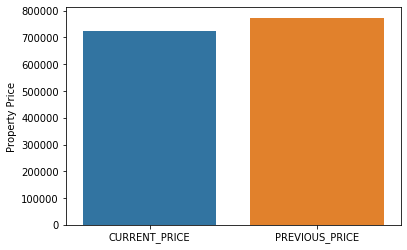

In [80]:
import seaborn as sns
# --- Write your code below ---
median_current_price = df_sample['CURRENT_PRICE'].median()
previous_median_price = df_sample['PREVIOUS_PRICE'].median()

y=[median_current_price,previous_median_price]
x=['CURRENT_PRICE','PREVIOUS_PRICE']

ax = sns.barplot(x, y)
plt.ylabel('Property Price')
plt.show()


### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, and compute a 95%-confidence interval for each number. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

In [81]:
house_price_list_curr = []
house_price_list_prev = []
# --- Write your code below ---
for i in range(1000):
    sample_median_curr_price = df_sample['CURRENT_PRICE'].sample(n=len(df_sample),replace=True).median()
    sample_median_prev_price = df_sample['PREVIOUS_PRICE'].sample(n=len(df_sample),replace=True).median()
    diff_in_curr_price = sample_median_curr_price - median_current_price 
    diff_in_prev_price = sample_median_prev_price - previous_median_price 
    house_price_list_curr.append(diff_in_curr_price)
    house_price_list_prev.append(diff_in_prev_price)
house_price_list_curr.sort(reverse=True)
house_price_list_prev.sort(reverse=True)
c99 = house_price_list_curr[10]
c5= house_price_list_curr[960]
print([median_current_price - c99,median_current_price-c5])
d99=house_price_list_prev[10]
d5=house_price_list_prev[960]
print([previous_median_price - d99,previous_median_price-d5])

[686000.0, 745050.0]
[737000.0, 806000.0]


## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.